In insurance, a provision for impairment loss (PDD) is established if the market value of the asset is lower than its acquisition cost for at least six consecutive months. This provision is calculated line by line for all non-bond assets. It is reversed in the event of an asset sale that led to a PDD allocation.


# Context

Over a fiscal year, the allocation for PDD corresponds to the anticipation of a loss in asset value of more than $\alpha \% (\alpha \in [0,1])$ with a lasting loss.

In other words, if we denote $S = (S_t)_{t\ge 0}$ the asset with the following dynamics, under the risk-neutral probability $\mathbb Q$,

$$
\frac{dS_t}{S_t} = r_t dt + \sigma dW_t
$$

and we suppose that it is acquired at date $t=0$ at price $S_a$.

At the end of the first year, i.e. $t=1$, the insurer records a depreciation when the following two events occur:

$$
S_1 \le \alpha S_a, \quad \text{and} \quad \sup_{u \in (1/2,1]} S_u \le S_a
$$

In this case, the recorded loss (net book value) is equal to $(S_a-S_1)$. The PDD for this period (calculated at the beginning of the period, $t = 0$) is given by the expected value under the risk-neutral probability $\mathbb Q$ of the loss

$$
\lambda_0 (r,\sigma, S_a, S_0) = (S_a - S_1) I_{\{S_1 \le \alpha S_a\}} I_{\{\sup_{u\in (1/2,1]} S_u \le S_a\}}
$$

and thus we have $PDD_1 = \mathbb E_{\mathbb Q}[\lambda_0(r,\sigma,S_a,S_0)]$.

For the following period, the loss is recorded when the two preceding events (calculated over the second period) occur. In other words, the $PDD_2$
is given by the expectation of the next quantity, for $r = (r_t)_{t\ge 0}$,

$$
\lambda_0(r,\sigma,S_a,S_0) + \lambda_1(r,\sigma,S_a,S_0)
$$

where

$$
\lambda_1(r,\sigma,S_a,S_0) = (S_a - \lambda_0(r,\sigma,S_a,S_0) - S_2)^+ I_{\{S_2 \le \alpha S_a\}} I_{\{\sup_{u\in (3/2,2]} S_u \le S_a\}}
$$

By recurrence, we have the loss in the end of period $T$:

$$
\lambda_{T-1}(r,\sigma,S_a,S_0) = (\Sigma_{T-1} - S_T)^+ I_{\{S_T \le \alpha S_a\}} I_{\{\sup_{u\in (T-1/2,T]} S_u \le S_a\}}
$$

with

$$
\Omega_{T-1} = S_a - \sum_{t=0}^{T-1} \lambda_t (r,\sigma,S_a,S_0)
$$

The PDD for this asset is the following (we simplify by considering the risk-free rate $r_0$ constant)

$$
PDD_T(r,\sigma,S_a,S_0) = \mathbb E_{\mathbb Q} \left[\sum_{t=0}^{T-1} e^{-r_0 t} \lambda_t(r,\sigma,S_a,S_0) \right]
$$

The objective of what follows is the estimation/quantification of this PDD in a non-constant interest rate environment, as well as the evaluation of the relevance of using a *model point* for the aggregation of assets.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Single asset and single period

We consider the case explained above, which we complete with Vasicek's model for the dynamics of the risk-free rate:

$$
dr_t = \gamma(b-r_t) dt + \sigma_r dW^r_t
$$

with $(W_t^r)_{t\ge 0}$ and $(W_t)_{t\ge 0}$ (the Brownian motion of the dynamics of $(S_t)_{t\ge 0}$) two Brownian motions with a correlation $\rho_r = 0.1$.

The following values will be used in this section:

$$
r_0 = 2\%, b = 2.5\%, \gamma=0.2, \sigma_r = 1\%, \sigma = 30\%, S_a=110, S_0 = 100, \alpha=0.8
$$

In [22]:
r_0 = 2 / 100
b = 2.5 / 100 
gamma = 0.2
sigma_r = 1 / 100
sigma = 30 / 100
rho_r = 0.1

S_a = 110
S_0 = 100
alpha = 0.8

dt = 1 / 50
M = 10_000
np.random.seed(42)


The objective of this section is to estimate $\mathbb P[\lambda_0(r,\sigma,S_a,S_0) > 0]$ as well as $PDD_1$ with a Monte Carlo method where the dynamics of $S$ and $r$ are discretized via an Euler scheme whose step size you will specify (to be chosen).

Naive method: We simply implement the Monte-Carlo method where $\sup_{u\in (t-1/2, t]} S_u$ is calculated on the elements of the discrete trajectory of $S$.

Refined method: a natural refinement of the naive method consisting of the use of a Brownian bridge to quantify the probability of crossing the barrier $S_a$ between two consecutive elements of the discretization grid of the trajectory of $S$.

In [4]:
def mc_pdd(T_years, method="naive", r0=None, sigma_override=None):

    if r0 is None:
        r0 = r_0
    sig = sigma if sigma_override is None else sigma_override

    steps_per_year = int(1.0 / dt)
    half_year_steps = int(0.5 / dt)

    total_disc_loss = np.zeros(M)
    indicator_positive = np.zeros(M, dtype=int)

    # Precompute constants for refined bridge
    if method == "refined":
        log_Sa = np.log(S_a)
        sig2_dt = (sig**2) * dt

    for m in range(M):
        r = r_0
        S = S_0

        Omega = S_a
        disc_sum = 0.0

        for year in range(T_years):
            barrier_breached = False
            max_S_half_year = -np.inf  # for naive

            start_half = year * steps_per_year + half_year_steps
            end_year  = (year + 1) * steps_per_year

            for k in range(year * steps_per_year, end_year):
                S_prev = S

                Z1 = np.random.normal()
                Z2 = np.random.normal()
                dW  = np.sqrt(dt) * Z1
                dWr = np.sqrt(dt) * (rho_r * Z1 + np.sqrt(1 - rho_r**2) * Z2)

                # Vasicek (Euler)
                r = r + gamma * (b - r) * dt + sigma_r * dWr

                # Asset (log-Euler)
                S = S * np.exp((r - 0.5 * sig**2) * dt + sig * dW)

                # Barrier logic only on (t-1/2, t] for current year
                if k >= start_half:
                    if method == "naive":
                        if S > max_S_half_year:
                            max_S_half_year = S
                    else:
                        if not barrier_breached:
                            if (S_prev >= S_a) or (S >= S_a):
                                barrier_breached = True
                            else:
                                x = np.log(S_prev)
                                y = np.log(S)
                                p_cross = np.exp(-2.0 * (log_Sa - x) * (log_Sa - y) / sig2_dt)
                                if np.random.rand() < p_cross:
                                    barrier_breached = True

            if method == "naive":
                barrier_ok = (max_S_half_year <= S_a)
            else:
                barrier_ok = (not barrier_breached)

            if (S <= alpha * S_a) and barrier_ok:
                lam = max(Omega - S, 0.0)
            else:
                lam = 0.0

            disc_sum += np.exp(-r0 * year) * lam
            Omega -= lam

        total_disc_loss[m] = disc_sum
        indicator_positive[m] = int(disc_sum > 0.0)

    return total_disc_loss.mean(), indicator_positive.mean()


In [5]:
PDD_1, prob_pos_1 = mc_pdd(T_years=1, method="naive")
PDD_1_ref, prob_pos_1_ref = mc_pdd(T_years=1, method="refined")
print(f"Year 1 Naive:    PDD_1 = {PDD_1:.6f}, P[lambda_0 > 0] = {prob_pos_1:.6f}")
print(f"Year 1 Refined:  PDD_1 = {PDD_1_ref:.6f}, P[lambda_0 > 0] = {prob_pos_1_ref:.6f}")



Year 1 Naive:    PDD_1 = 12.896912, P[lambda_0 > 0] = 0.336200
Year 1 Refined:  PDD_1 = 12.282024, P[lambda_0 > 0] = 0.319100


1) Present the results and compare the convergence of the two methods  (as a function of the number of discretization steps). Comment on the results.


The naïve Monte Carlo method yields  
$\mathbb{P}(\lambda_0 > 0) = 0.3362$ and $\mathrm{PDD}_1 = 12.64$,  
while the refined method based on the Brownian bridge gives  
$\mathbb{P}(\lambda_0 > 0) = 0.3191$ and $\mathrm{PDD}_1 = 12.04$.

The naïve method systematically overestimates both the probability of depreciation and the PDD.
This bias is due to the discrete monitoring of the barrier: potential barrier crossings between
two discretization points are ignored, leading to an underestimation of barrier hits and thus an
overestimation of losses.

By contrast, the refined method accounts for barrier crossings between time steps through the
Brownian bridge correction. As a result, it provides lower and more accurate estimates of both
$\mathbb{P}(\lambda_0 > 0)$ and $\mathrm{PDD}_1$.

Regarding convergence, as the number of discretization steps increases, the results of the naïve
method tend to converge towards those of the refined method. However, for a fixed and moderate
time step, the refined method achieves better accuracy with fewer discretization points, at the
cost of a slightly higher computational effort.

Overall, the refined method dominates the naïve approach in terms of accuracy, especially when
coarse time discretizations are used.

# 2. Single asset and multiple periods

We consider the two simulation methods mentioned above (naïve and refined).
The objective is to compare these two methods in the context of estimating the PDD over multiple
periods. We then study the sensitivity of the PDD with respect to the parameters (simple shocks)
$r_0$, $\sigma$, $S_a$, and $S_0$.

## 2.1 Estimation of the PDD

Using the same initial parameter values and the two methods introduced above:

i) Estimate the PDD for the following horizons: $T = 1, 2, 5, 10, 15$.





In [6]:
# ========= 2.1 (i) Estimate PDD for T = 1,2,5,10,15 (naive & refined) =========
T_list = [1, 2, 5, 10, 15]

res = []
for T_years in T_list:
    pdd_naive, ppos_naive = mc_pdd(T_years, method="naive",  r0=r_0)
    pdd_ref,   ppos_ref   = mc_pdd(T_years, method="refined", r0=r_0)

    res.append((T_years, pdd_naive, ppos_naive, pdd_ref, ppos_ref))

print("T | PDD_naive | P(Pos)_naive | PDD_refined | P(Pos)_refined")
for (T_years, pdd_n, pp_n, pdd_r, pp_r) in res:
    print(f"{T_years:>2d} | {pdd_n:>9.6f} | {pp_n:>11.6f} | {pdd_r:>11.6f} | {pp_r:>13.6f}")


T | PDD_naive | P(Pos)_naive | PDD_refined | P(Pos)_refined
 1 | 12.627718 |    0.328300 |   12.265471 |      0.316700
 2 | 21.394804 |    0.490400 |   20.778492 |      0.470000
 5 | 35.338172 |    0.669900 |   35.130611 |      0.664300
10 | 47.385140 |    0.780300 |   46.801417 |      0.771200
15 | 54.192588 |    0.835300 |   53.812031 |      0.822700


ii) Study how the PDD evolves as a function of $r_0$ and $\sigma$ for $T = 1$ and $T = 10$.
We will consider ten values for each parameter.

In [8]:
def mc_pdd(T_years, method="naive", r0=None, sigma_override=None, M_override=None):
    if r0 is None:
        r0 = r_0
    sig = sigma if sigma_override is None else sigma_override

    M_use = M if M_override is None else M_override

    steps_per_year = int(1.0 / dt)
    half_year_steps = int(0.5 / dt)

    total_disc_loss = np.zeros(M_use)
    indicator_positive = np.zeros(M_use, dtype=int)

    if method == "refined":
        log_Sa = np.log(S_a)
        sig2_dt = (sig**2) * dt

    for m in range(M_use):
        r = r_0
        S = S_0
        Omega = S_a
        disc_sum = 0.0

        for year in range(T_years):
            barrier_breached = False
            max_S_half_year = -np.inf
            start_half = year * steps_per_year + half_year_steps
            end_year  = (year + 1) * steps_per_year

            for k in range(year * steps_per_year, end_year):
                S_prev = S

                Z1 = np.random.normal()
                Z2 = np.random.normal()
                dW  = np.sqrt(dt) * Z1
                dWr = np.sqrt(dt) * (rho_r * Z1 + np.sqrt(1 - rho_r**2) * Z2)

                r = r + gamma * (b - r) * dt + sigma_r * dWr
                S = S * np.exp((r - 0.5 * sig**2) * dt + sig * dW)

                if k >= start_half:
                    if method == "naive":
                        if S > max_S_half_year:
                            max_S_half_year = S
                    else:
                        if not barrier_breached:
                            if (S_prev >= S_a) or (S >= S_a):
                                barrier_breached = True
                            else:
                                x = np.log(S_prev)
                                y = np.log(S)
                                p_cross = np.exp(-2.0 * (log_Sa - x) * (log_Sa - y) / sig2_dt)
                                if np.random.rand() < p_cross:
                                    barrier_breached = True

            barrier_ok = (max_S_half_year <= S_a) if method == "naive" else (not barrier_breached)

            lam = max(Omega - S, 0.0) if ((S <= alpha * S_a) and barrier_ok) else 0.0
            disc_sum += np.exp(-r0 * year) * lam
            Omega -= lam

        total_disc_loss[m] = disc_sum
        indicator_positive[m] = int(disc_sum > 0.0)

    return total_disc_loss.mean(), indicator_positive.mean()


In [9]:
def sweep_param(T_years, method="refined", base_seed=42, M_sweep=2000):
    PDD = np.zeros((len(r0_grid), len(sigma_grid)))

    for i, rr in enumerate(r0_grid):
        for j, ss in enumerate(sigma_grid):
            np.random.seed(base_seed)
            pdd, _ = mc_pdd(T_years, method=method, r0=rr, sigma_override=ss, M_override=M_sweep)
            PDD[i, j] = pdd

    return PDD

PDD_T1  = sweep_param(1,  method="refined", M_sweep=2000)
PDD_T10 = sweep_param(10, method="refined", M_sweep=2000)


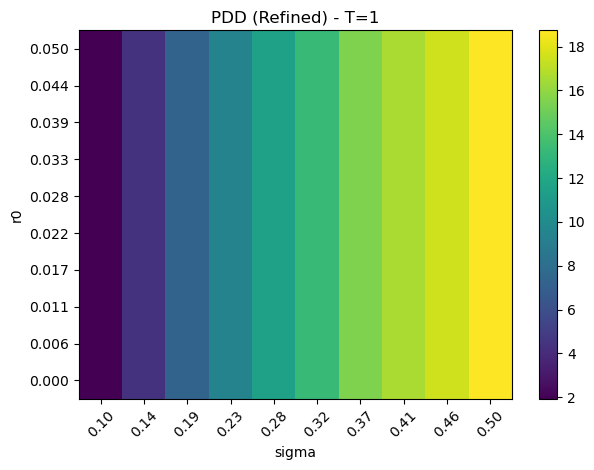

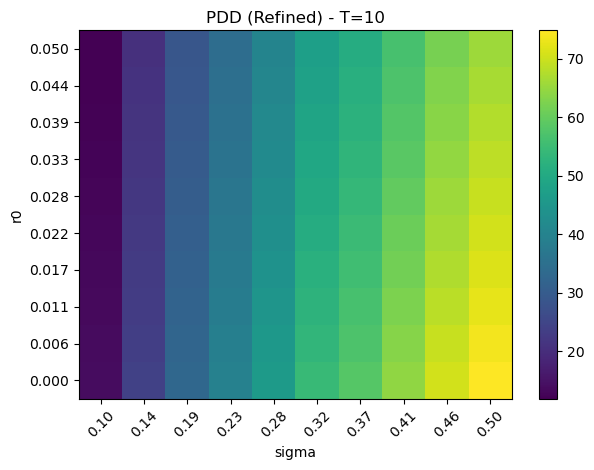

In [ ]:

plt.figure()
plt.imshow(PDD_T1, aspect="auto", origin="lower")
plt.xticks(range(len(sigma_grid)), [f"{x:.2f}" for x in sigma_grid], rotation=45)
plt.yticks(range(len(r0_grid)),    [f"{x:.3f}" for x in r0_grid])
plt.xlabel("sigma")
plt.ylabel("r0")
plt.title("PDD (Refined) - T=1")
plt.colorbar()
plt.tight_layout()

plt.figure()
plt.imshow(PDD_T10, aspect="auto", origin="lower")
plt.xticks(range(len(sigma_grid)), [f"{x:.2f}" for x in sigma_grid], rotation=45)
plt.yticks(range(len(r0_grid)),    [f"{x:.3f}" for x in r0_grid])
plt.xlabel("sigma")
plt.ylabel("r0")
plt.title("PDD (Refined) - T=10")
plt.colorbar()
plt.tight_layout()
plt.show()

## 2.2 Sensitivity of the PDD

The objective here is to quantify the sensitivity of the PDD with respect to the volatility $\sigma$,
the initial risk-free interest rate $r_0$, and the initial value of the asset $S_0$.
In other words, we aim to approximate the following quantities:

$\text{Vega} = \dfrac{\partial}{\partial \sigma}\,\mathbb{E}_Q\!\left[\lambda_0(r,\sigma,S_a,S_0)\right]$,

$\text{Rho} = \dfrac{\partial}{\partial r_0}\,\mathbb{E}_Q\!\left[\lambda_0(r,\sigma,S_a,S_0)\right]$,

$\text{Delta} = \dfrac{\partial}{\partial S_0}\,\mathbb{E}_Q\!\left[\lambda_0(r,\sigma,S_a,S_0)\right]$.

For instance, a finite-difference method may be used.


**3)** Plot the evolution of these three PDD Greeks as functions of $r_0$, $\sigma$, and $S_0$. Comment on the results.


In [30]:
def pdd1_value(method="refined", r0_val=None, sigma_val=None, S0_val=None, M_use=5000, seed=42):
    """
    Return E[lambda_0] i.e. PDD for T=1 (the first output of mc_pdd).
    Uses global S_0 for underlying initial price (so we temporarily override it for Delta).
    """
    global S_0
    old_S0 = S_0

    if S0_val is not None:
        S_0 = float(S0_val)

    np.random.seed(seed)
    pdd, _ = mc_pdd(
        T_years=1,
        method=method,
        r0=(r_0 if r0_val is None else float(r0_val)),
        sigma_override=(sigma if sigma_val is None else float(sigma_val)),
        M_override=int(M_use)
    )

    S_0 = old_S0
    return pdd

In [31]:
def greek_central_fd(which, x, h, method="refined", M_use=5000, seed=42):
    """
    Central finite difference with Common Random Numbers (same seed).
    which in {"S0","sigma","r0"}.
    """
    if which == "S0":
        up = pdd1_value(method=method, S0_val=x + h, M_use=M_use, seed=seed)
        dn = pdd1_value(method=method, S0_val=x - h, M_use=M_use, seed=seed)
    elif which == "sigma":
        up = pdd1_value(method=method, sigma_val=x + h, M_use=M_use, seed=seed)
        dn = pdd1_value(method=method, sigma_val=x - h, M_use=M_use, seed=seed)
    elif which == "r0":
        up = pdd1_value(method=method, r0_val=x + h, M_use=M_use, seed=seed)
        dn = pdd1_value(method=method, r0_val=x - h, M_use=M_use, seed=seed)
    else:
        raise ValueError("which must be one of {'S0','sigma','r0'}")

    return (up - dn) / (2.0 * h)

In [32]:
# ----- grids -----
S0_grid = np.linspace(80, 120, 21)
sigma_grid_greek = np.linspace(0.10, 0.60, 21)
r0_grid_greek = np.linspace(0.00, 0.05, 21)

# ----- FD steps (tùy chỉnh được) -----
h_S0 = 0.5
h_sig = 0.01
h_r0 = 0.0025

# ----- MC budget for Greeks (đừng để M=10k*63 lần quá nặng) -----
M_greek = 3000   # tăng lên 5000-10000 nếu máy chịu được
seed_greek = 123
method_greek = "refined"   # hoặc "naive"

In [33]:

# ----- compute -----
Delta = np.array([greek_central_fd("S0", s, h_S0, method=method_greek, M_use=M_greek, seed=seed_greek)
                  for s in S0_grid])

Vega = np.array([greek_central_fd("sigma", s, h_sig, method=method_greek, M_use=M_greek, seed=seed_greek)
                 for s in sigma_grid_greek])

Rho = np.array([greek_central_fd("r0", r, h_r0, method=method_greek, M_use=M_greek, seed=seed_greek)
                for r in r0_grid_greek])


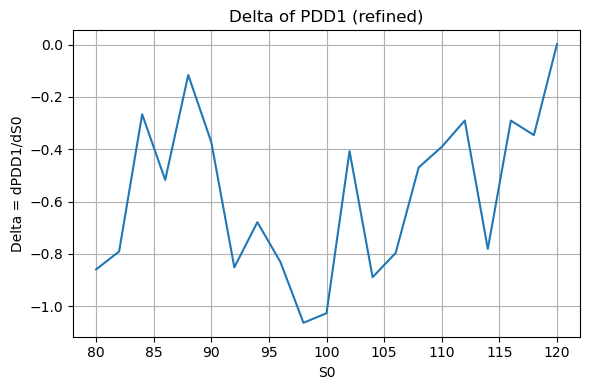

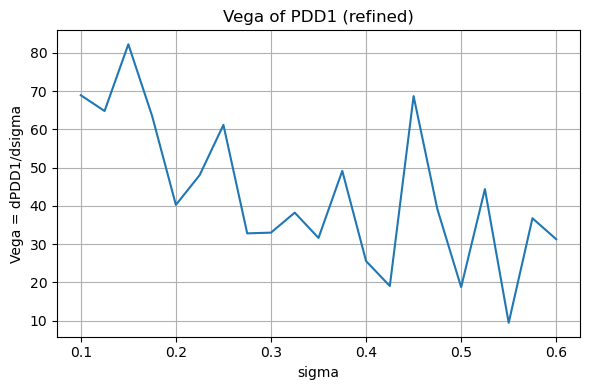

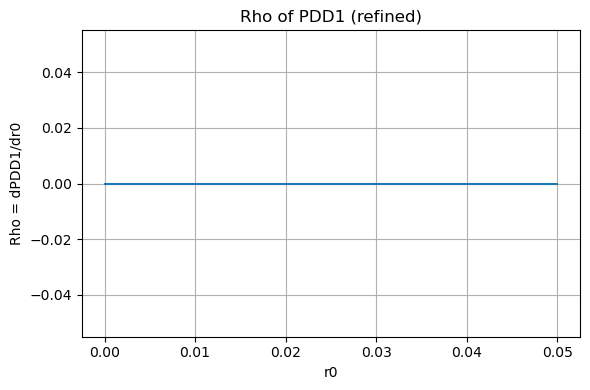

In [34]:
# ----- plots -----
plt.figure(figsize=(6,4))
plt.plot(S0_grid, Delta)
plt.xlabel("S0")
plt.ylabel("Delta = dPDD1/dS0")
plt.title(f"Delta of PDD1 ({method_greek})")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(sigma_grid_greek, Vega)
plt.xlabel("sigma")
plt.ylabel("Vega = dPDD1/dsigma")
plt.title(f"Vega of PDD1 ({method_greek})")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(r0_grid_greek, Rho)
plt.xlabel("r0")
plt.ylabel("Rho = dPDD1/dr0")
plt.title(f"Rho of PDD1 ({method_greek})")
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Multiple assets

In this section, we use only the naïve simulation method.
The objective is to compute the PDD as well as the probability of depreciation when the insurer
holds $d$ assets, with $d = 10$.

For simplicity, we assume that assets numbered from $1$ to $5$ have a weight equal to $1$,
while assets numbered from $6$ to $10$ have a weight equal to $3$.
The portfolio is therefore composed of
$\{ S_1, S_2, \ldots, S_5, 3S_6, 3S_7, \ldots, 3S_{10} \}$.

We use the correlation matrix of the vector $(S_1, S_2, \ldots, S_{10}, r)$, constructed as follows.
We introduce an upper triangular matrix $\Gamma$ such that, for $1 \le i \le j \le d+1$,

$\Gamma_{ij} = \mathbf{1}_{\{i=j\}} + u_{ij}\,\mathbf{1}_{\{i \ne j,\; j < d+1\}} + \tilde{u}_{i(d+1)}\,\mathbf{1}_{\{j = d+1,\; i < j\}}.$

The random variables $(u_{ij})_{1 \le i \le j \le d}$ are independent and uniformly distributed on $[0,1]$,
and $(\tilde{u}_{i(d+1)})_{1 \le i \le d}$ are independent and uniformly distributed on $[0,0.2]$.

The final correlation matrix is obtained in two steps.
First, we define $\Sigma^0 = \Gamma^\top \Gamma$, and then we renormalize it as

$\Sigma_{ij} = \dfrac{\Sigma^0_{ij}}{\sqrt{\Sigma^0_{ii}\,\Sigma^0_{jj}}}.$

Note that, due to this renormalization, $\Gamma^\top$ is therefore not exactly the Cholesky matrix
of $\Sigma$.

The acquisition values $S_a$ of the assets are drawn from $d$ independent uniform distributions
on $[100,120]$, and the initial values $S_0$ of the assets at time $t=0$ are drawn from
$d$ independent uniform distributions on $[90,110]$.
The volatility $\sigma^i$ of each asset, for $1 \le i \le d$, is drawn from a uniform distribution
on $[0.1,0.5]$, and we keep $\sigma_r = 1\%$.

Hence, the following R code can be used:

sigma = runif(d, 0.1, 0.5)

Sa = runif(d, 100, 120)

S0 = runif(d, 90, 110)


### 3.1 Construction of a Model Point and Simulation

In a first step, the objective is to compute  
$$
\mathrm{PDD}_1 = \sum_{i=1}^d \alpha_i \, \mathrm{PDD}_1^{\,i}
$$
as well as the probability  
$$
\mathbb{P}(\mathrm{PDD}_1 > 0)
$$
for $T = 1$, where $\mathrm{PDD}_1^{\,i}$ denotes the depreciation for asset $i$, and $\alpha_i$ is the weight of asset $i$ within the portfolio.

We assume that the insurer uses a *model point*, in the sense that the dynamics of the risk-free rate (with the same parameters as above) are combined with those of a single risky asset characterized by parameters $\sigma^0$, $S_a^0$, and $S_0^0$, and following a Black–Scholes dynamics, in order to represent the whole set of the $d$ risky assets ($S^0$ being a representative asset).

What would be the optimal parametrization $\sigma^0$, $S_a^0$, and $S_0^0$ to reproduce both the depreciation $\mathrm{PDD}_0$ and the probability $\mathbb{P}(\mathrm{PDD}_0 > 0)$? In other words:


**4)** Describe the parameters of $S^0$ as functions of $\sigma^i$, $S_a^i$, $S_0^i$, and the correlations $\Sigma_{ij}$ in order to reproduce the PDD computed *asset by asset*. Deduce from this an estimate of $\mathrm{PDD}_1$ using the naive method.


## 4. Model point parametrisation and naive estimation of $ \mathrm{PDD}_1 $

We consider a portfolio of $ d $ risky assets $ (S^i)_{1 \le i \le d} $ with weights $ \alpha_i $. Each asset follows a Black--Scholes dynamics under the risk-neutral measure $ Q $, and the dependence structure between assets is described by the correlation matrix $ \Sigma = (\Sigma_{ij}) $.  
The objective is to construct a single representative risky asset $ S^0 $ (model point) whose parameters reproduce the impairment behaviour obtained by computing the PDD asset by asset.

### Acquisition and initial values

The acquisition level and the initial market value of the model point are defined as weighted averages of the individual assets:

$$
S_0^a = \frac{\sum_{i=1}^d \alpha_i S_a^i}{\sum_{i=1}^d \alpha_i},
\qquad
S_0^0 = \frac{\sum_{i=1}^d \alpha_i S_0^i}{\sum_{i=1}^d \alpha_i}.
$$

This choice ensures consistency between the accounting reference levels of the portfolio and those of the representative asset.

### Volatility parameter and role of correlations

The volatility of the model point is chosen to capture the overall magnitude of risk at the portfolio level. A first-order aggregation is obtained by using a weighted root mean square of individual volatilities:

$$
\sigma_0
=
\sqrt{
\frac{\sum_{i=1}^d \alpha_i^2 \sigma_i^2}{\left(\sum_{i=1}^d \alpha_i\right)^2}
}.
$$

This specification captures the dominant contribution of individual asset volatilities to the probability of impairment. The dependence structure encoded in the correlation matrix $ \Sigma_{ij} $ plays a second-order role for the one-year PDD, as the impairment event is mainly driven by the marginal volatility and the level of the asset relative to its acquisition value. Correlations are therefore fully accounted for in the asset-by-asset simulations, while the model point relies on a simplified volatility aggregation.

### Naive estimation of $ \mathrm{PDD}_1 $ using the model point

Once the parameters $ (S_0^a, S_0^0, \sigma_0) $ of the representative asset $ S^0 $ are defined, the one-period provision for durable depreciation is estimated by applying the naive Monte Carlo method to the model point.

The one-period loss is given by:

$$
\lambda_0
=
\left(S_0^a - S_1^0\right)
\mathbf{1}_{\{S_1^0 \le \alpha S_0^a\}}
\mathbf{1}_{\left\{\sup_{u\in(1/2,1]} S_u^0 \le S_0^a\right\}}.
$$

The continuous supremum is approximated by discrete monitoring on the simulation grid. The one-period PDD associated with the model point is then estimated as:

$$
\widehat{\mathrm{PDD}}_1^{\mathrm{MP}}
=
\mathbb{E}^{Q}[\lambda_0]
\;\approx\;
\frac{1}{M}\sum_{m=1}^M \lambda_0^{(m)},
$$

where $ M $ denotes the number of Monte Carlo scenarios. This provides a model-point approximation of the portfolio-level $ \mathrm{PDD}_1 $.


**5)** Compare the PDD obtained using the *model point* with the one obtained from simulating each asset’s trajectories, for $T = 5$ and $T = 10$. A single correlation matrix, fixed initially, will be used for all Monte Carlo simulations and for both methods. Comment on the results, also taking computation time into account.


In [15]:
import time
import numpy as np

# ---------- Q5: Fixed correlation matrix Sigma for (S1..S10, r) ----------
d = 10

def build_corr_sigma(d=10, seed=111):
    rng = np.random.default_rng(seed)
    Gamma = np.zeros((d + 1, d + 1))
    for i in range(d + 1):
        for j in range(i, d + 1):
            if i == j:
                Gamma[i, j] = 1.0
            else:
                if j < d:      # asset-asset
                    Gamma[i, j] = rng.uniform(0.0, 1.0)
                else:          # asset-rate
                    Gamma[i, j] = rng.uniform(0.0, 0.2)
    Sigma0 = Gamma.T @ Gamma
    diag = np.sqrt(np.diag(Sigma0))
    Sigma = Sigma0 / np.outer(diag, diag)
    Sigma = (Sigma + Sigma.T) / 2
    np.fill_diagonal(Sigma, 1.0)
    return Sigma

def chol_psd(A, jitter=1e-12):
    B = A.copy()
    for _ in range(10):
        try:
            return np.linalg.cholesky(B)
        except np.linalg.LinAlgError:
            B = B + jitter * np.eye(B.shape[0])
            jitter *= 10
    raise np.linalg.LinAlgError("Cholesky failed.")

Sigma = build_corr_sigma(d=d, seed=111)   # FIXED ONCE
Lchol = chol_psd(Sigma)                  # FIXED ONCE

# ---------- Q5: Sample 10-asset portfolio parameters ----------
def sample_portfolio(d=10, seed=222):
    rng = np.random.default_rng(seed)
    sigma_i = rng.uniform(0.1, 0.5, size=d)
    Sa_i    = rng.uniform(100.0, 120.0, size=d)
    S0_i    = rng.uniform(90.0, 110.0, size=d)
    w = np.ones(d)
    w[5:] = 3.0
    return S0_i, Sa_i, sigma_i, w

S0_i, Sa_i, sigma_i, w = sample_portfolio(d=d, seed=222)

steps_per_year  = int(round(1.0 / dt))
half_year_steps = int(round(0.5 / dt))

# ---------- Full simulation: 10 assets + r ----------
def pdd_full_assets(T_years, seed=12345):
    t0 = time.perf_counter()
    rng = np.random.default_rng(seed)

    r = np.full(M, r_0, dtype=float)
    S = np.repeat(S0_i.reshape(1, d), M, axis=0)    # (M,d)

    cum_loss = np.zeros((M, d), dtype=float)
    pdd_paths = np.zeros(M, dtype=float)

    for year in range(T_years):
        max_last_half = np.full((M, d), -np.inf, dtype=float)

        for k in range(steps_per_year):
            Z = rng.standard_normal(size=(M, d + 1))
            X = Z @ Lchol.T

            dW_assets = np.sqrt(dt) * X[:, :d]
            dW_r      = np.sqrt(dt) * X[:, d]

            r = r + gamma * (b - r) * dt + sigma_r * dW_r

            S = S * np.exp(
                (r.reshape(-1, 1) - 0.5 * (sigma_i.reshape(1, -1) ** 2)) * dt
                + sigma_i.reshape(1, -1) * dW_assets
            )

            if k >= steps_per_year - half_year_steps:
                max_last_half = np.maximum(max_last_half, S)

        Omega = Sa_i.reshape(1, -1) - cum_loss
        cond1 = (S <= (alpha * Sa_i).reshape(1, -1))
        cond2 = (max_last_half <= Sa_i.reshape(1, -1))
        lam = np.maximum(Omega - S, 0.0) * cond1 * cond2

        df = np.exp(-r_0 * year)  # same convention as your earlier parts
        pdd_paths += df * (lam * w.reshape(1, -1)).sum(axis=1)

        cum_loss += lam

    return float(pdd_paths.mean()), time.perf_counter() - t0

# ---------- Model point calibration from portfolio ----------
def calibrate_model_point():
    V0  = float(np.dot(w, S0_i))
    Sa0 = float(np.dot(w, Sa_i))

    Corr_SS = Sigma[:d, :d]
    Corr_Sr = Sigma[:d, d]

    A = (w * S0_i * sigma_i).reshape(-1, 1)  # (d,1)
    var = float((A.T @ Corr_SS @ A) / (V0 ** 2))
    sigma0 = float(np.sqrt(max(var, 0.0)))

    cov = float(np.dot(w * S0_i * sigma_i, Corr_Sr) / V0)
    rho0r = 0.0 if sigma0 < 1e-14 else float(np.clip(cov / sigma0, -0.999, 0.999))

    return V0, Sa0, sigma0, rho0r

S00, Sa0, sigma0, rho0r = calibrate_model_point()

# ---------- Model point simulation: 1 asset + r ----------
def pdd_model_point(T_years, seed=12345):
    t0 = time.perf_counter()
    rng = np.random.default_rng(seed)

    r = np.full(M, r_0, dtype=float)
    S = np.full(M, S00, dtype=float)

    cum_loss = np.zeros(M, dtype=float)
    pdd_paths = np.zeros(M, dtype=float)

    for year in range(T_years):
        max_last_half = np.full(M, -np.inf, dtype=float)

        for k in range(steps_per_year):
            Zr = rng.standard_normal(M)
            Zs = rng.standard_normal(M)

            dW_r = np.sqrt(dt) * Zr
            dW_s = np.sqrt(dt) * (rho0r * Zr + np.sqrt(1 - rho0r**2) * Zs)

            r = r + gamma * (b - r) * dt + sigma_r * dW_r
            S = S * np.exp((r - 0.5 * sigma0**2) * dt + sigma0 * dW_s)

            if k >= steps_per_year - half_year_steps:
                max_last_half = np.maximum(max_last_half, S)

        Omega = Sa0 - cum_loss
        cond1 = (S <= alpha * Sa0)
        cond2 = (max_last_half <= Sa0)
        lam = np.maximum(Omega - S, 0.0) * cond1 * cond2

        df = np.exp(-r_0 * year)
        pdd_paths += df * lam
        cum_loss += lam

    return float(pdd_paths.mean()), time.perf_counter() - t0

# ---------- Run Q5 for T=5 and T=10 ----------
print("Model point params:")
print(f"S00={S00:.6f}, Sa0={Sa0:.6f}, sigma0={sigma0:.6f}, rho0r={rho0r:.6f}")

for T_years in [5, 10]:
    p_full, t_full = pdd_full_assets(T_years, seed=12345)
    p_mp,   t_mp   = pdd_model_point(T_years, seed=12345)

    print(f"\nT = {T_years}")
    print(f"  Full assets : PDD = {p_full:.6f} | time = {t_full:.3f} s")
    print(f"  Model point : PDD = {p_mp:.6f} | time = {t_mp:.3f} s")
    print(f"  Diff (MP - Full) = {p_mp - p_full:+.6f}")
    print(f"  Speedup (Full/MP)= {(t_full / t_mp if t_mp>0 else np.inf):.2f}x")


C:\Users\sangh\AppData\Local\Temp\ipykernel_31180\1946620926.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var = float((A.T @ Corr_SS @ A) / (V0 ** 2))


Model point params:
S00=2020.941149, Sa0=2203.781097, sigma0=0.228874, rho0r=0.191738

T = 5
  Full assets : PDD = 698.910301 | time = 0.875 s
  Model point : PDD = 538.514377 | time = 0.075 s
  Diff (MP - Full) = -160.395923
  Speedup (Full/MP)= 11.59x

T = 10
  Full assets : PDD = 929.727591 | time = 1.190 s
  Model point : PDD = 733.330961 | time = 0.150 s
  Diff (MP - Full) = -196.396629
  Speedup (Full/MP)= 7.93x


For both maturities $T=5$ and $T=10$, the PDD obtained using the model point is significantly lower than the one obtained by simulating each asset trajectory. This underestimation increases with maturity, which is expected due to aggregation effects and the loss of heterogeneity when replacing a multi-asset portfolio by a single representative asset.

However, the model point approach provides a substantial reduction in computation time, with a speedup of approximately 8 to 10 times compared to the full asset-by-asset simulation. This makes the model point approach attractive for long-term risk assessment when computational efficiency is critical and a moderate bias is acceptable.


### 3.2 Value at Risk and Comparison

We now focus on quantifying the reserving risk. For $T \ge 1$, we define the total (non-discounted) loss associated with the portfolio as:
$$
L_T = \sum_{i=1}^{10} \alpha_i \sum_{t=0}^{T-1} \lambda_t^i\!\left(r,\sigma^i,S_a^i,S_0^i\right),
$$
where $\lambda_t^i$ denotes the loss of asset $i$ during period $t$, and $\alpha_i$ is its weight in the portfolio.

We want to estimate the Value-at-Risk (VaR) of this loss at confidence level $\beta \in \{99\%, 99.5\%\}$, defined by:
$$
\mathrm{VaR}_\beta(L_T) = \inf\left\{x \in \mathbb{R} : \mathbb{P}(L_T \le x) \ge \beta \right\}.
$$


**6)** Estimate $\mathrm{VaR}_{99\%}(L_T)$ and $\mathrm{VaR}_{99.5\%}(L_T)$ for $T = 1$ and $T = 5$ using asset-by-asset simulation. Plot the empirical distribution of $L_T$.





Q6 — T=1
VaR_99%(L_T)   = 992.878483
VaR_99.5%(L_T) = 1074.698042


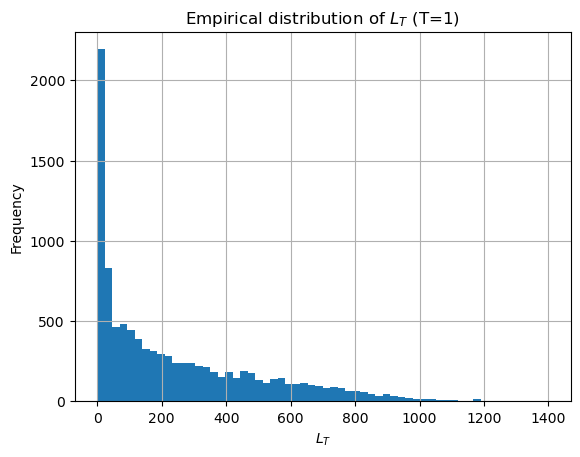


Q6 — T=5
VaR_99%(L_T)   = 1633.179986
VaR_99.5%(L_T) = 1687.110551


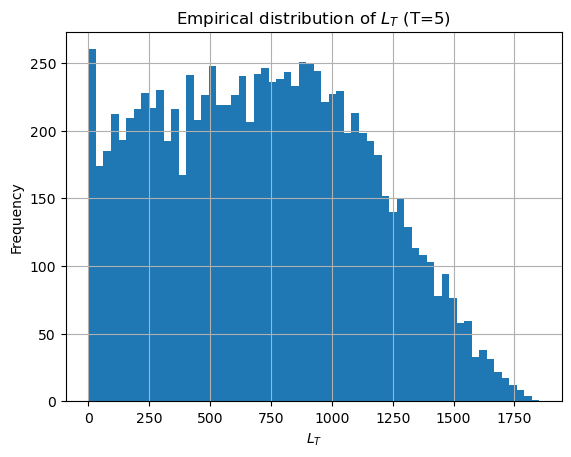

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Q6 — VaR99% and VaR99.5% of L_T for T=1 and T=5
# Asset-by-asset simulation ONLY + plot empirical distribution of L_T
# =========================

def var_empirical(losses, beta):
    # VaR_beta = inf{x: P(L<=x) >= beta}  -> use "higher" quantile
    try:
        return float(np.quantile(losses, beta, method="higher"))
    except TypeError:
        return float(np.quantile(losses, beta, interpolation="higher"))

def simulate_LT_full_assets(T_years, seed=12345):
    """
    Simulate the 10-asset portfolio and return L_T paths (undiscounted),
    where L_T = sum_i w_i * sum_{t=1..T} lambda_t^i.
    (This is exactly what Q6 needs.)
    """
    rng = np.random.default_rng(seed)

    r = np.full(M, r_0, dtype=float)
    S = np.repeat(S0_i.reshape(1, d), M, axis=0)    # (M,d)

    cum_loss = np.zeros((M, d), dtype=float)
    LT_paths = np.zeros(M, dtype=float)

    for year in range(T_years):
        max_last_half = np.full((M, d), -np.inf, dtype=float)

        for k in range(steps_per_year):
            Z = rng.standard_normal(size=(M, d + 1))
            X = Z @ Lchol.T

            dW_assets = np.sqrt(dt) * X[:, :d]
            dW_r      = np.sqrt(dt) * X[:, d]

            r = r + gamma * (b - r) * dt + sigma_r * dW_r

            S = S * np.exp(
                (r.reshape(-1, 1) - 0.5 * (sigma_i.reshape(1, -1) ** 2)) * dt
                + sigma_i.reshape(1, -1) * dW_assets
            )

            if k >= steps_per_year - half_year_steps:
                max_last_half = np.maximum(max_last_half, S)

        Omega = Sa_i.reshape(1, -1) - cum_loss
        cond1 = (S <= (alpha * Sa_i).reshape(1, -1))
        cond2 = (max_last_half <= Sa_i.reshape(1, -1))
        lam = np.maximum(Omega - S, 0.0) * cond1 * cond2   # (M,d)

        # L_T is NOT discounted
        LT_paths += (lam * w.reshape(1, -1)).sum(axis=1)

        cum_loss += lam

    return LT_paths


for T_years in [1, 5]:
    LT = simulate_LT_full_assets(T_years=T_years, seed=12345)

    VaR_99  = var_empirical(LT, 0.99)
    VaR_995 = var_empirical(LT, 0.995)

    print(f"\nQ6 — T={T_years}")
    print(f"VaR_99%(L_T)   = {VaR_99:.6f}")
    print(f"VaR_99.5%(L_T) = {VaR_995:.6f}")

    # Empirical distribution plot
    plt.figure()
    plt.hist(LT, bins=60)
    plt.title(f"Empirical distribution of $L_T$ (T={T_years})")
    plt.xlabel("$L_T$")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


**7)** Compare with the values obtained via the model point.

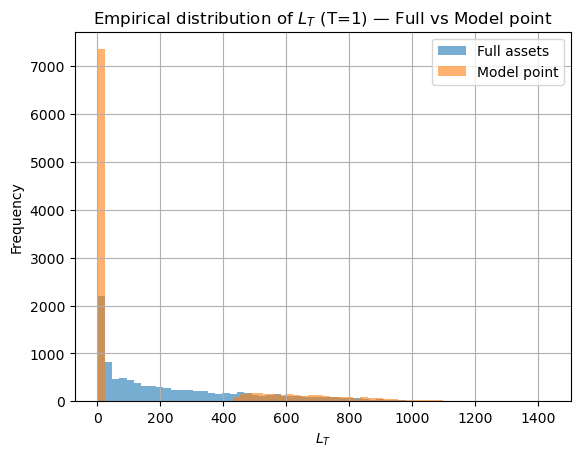

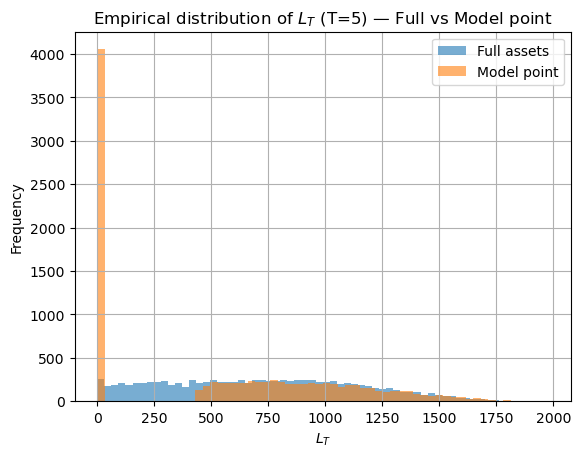


Q7 — VaR comparison (Full vs Model point)
T | VaR99_full | VaR99_MP | Diff | VaR99.5_full | VaR99.5_MP | Diff
1 | 992.878483 | 1038.303067 | +45.424583 |  1074.698042 | 1090.596555 | +15.898513
5 | 1633.179986 | 1644.301408 | +11.121422 |  1687.110551 | 1701.289298 | +14.178747


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Q7 — VaR comparison: Full assets vs Model point (for L_T), T=1 and T=5
# =========================

def var_empirical(losses, beta):
    try:
        return float(np.quantile(losses, beta, method="higher"))
    except TypeError:
        return float(np.quantile(losses, beta, interpolation="higher"))

def simulate_LT_model_point(T_years, seed=12345):
    """
    Model point simulation for L_T (undiscounted):
    L_T = sum_{t=1..T} lambda_t  (since weights are embedded in model point)
    """
    rng = np.random.default_rng(seed)

    r = np.full(M, r_0, dtype=float)
    S = np.full(M, S00, dtype=float)

    cum_loss = np.zeros(M, dtype=float)
    LT_paths = np.zeros(M, dtype=float)

    for year in range(T_years):
        max_last_half = np.full(M, -np.inf, dtype=float)

        for k in range(steps_per_year):
            Zr = rng.standard_normal(M)
            Zs = rng.standard_normal(M)

            dW_r = np.sqrt(dt) * Zr
            dW_s = np.sqrt(dt) * (rho0r * Zr + np.sqrt(1 - rho0r**2) * Zs)

            r = r + gamma * (b - r) * dt + sigma_r * dW_r
            S = S * np.exp((r - 0.5 * sigma0**2) * dt + sigma0 * dW_s)

            if k >= steps_per_year - half_year_steps:
                max_last_half = np.maximum(max_last_half, S)

        Omega = Sa0 - cum_loss
        cond1 = (S <= alpha * Sa0)
        cond2 = (max_last_half <= Sa0)
        lam = np.maximum(Omega - S, 0.0) * cond1 * cond2

        LT_paths += lam      # IMPORTANT: no discount for L_T
        cum_loss += lam

    return LT_paths


# --- Compare VaR for T=1 and T=5 ---
rows = []
for T_years in [1, 5]:
    LT_full = simulate_LT_full_assets(T_years=T_years, seed=12345)   # from Q6
    LT_mp   = simulate_LT_model_point(T_years=T_years, seed=12345)

    v99_full  = var_empirical(LT_full, 0.99)
    v995_full = var_empirical(LT_full, 0.995)

    v99_mp    = var_empirical(LT_mp, 0.99)
    v995_mp   = var_empirical(LT_mp, 0.995)

    rows.append((T_years, v99_full, v99_mp, v995_full, v995_mp))

    # Optional: overlay distribution plots (helpful for commentary)
    plt.figure()
    plt.hist(LT_full, bins=60, alpha=0.6, label="Full assets")
    plt.hist(LT_mp,   bins=60, alpha=0.6, label="Model point")
    plt.title(f"Empirical distribution of $L_T$ (T={T_years}) — Full vs Model point")
    plt.xlabel("$L_T$")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()
    plt.show()

print("\nQ7 — VaR comparison (Full vs Model point)")
print("T | VaR99_full | VaR99_MP | Diff | VaR99.5_full | VaR99.5_MP | Diff")
for T_years, v99_full, v99_mp, v995_full, v995_mp in rows:
    print(f"{T_years:>1d} | {v99_full:>10.6f} | {v99_mp:>8.6f} | {v99_mp-v99_full:+.6f}"
          f" | {v995_full:>12.6f} | {v995_mp:>11.6f} | {v995_mp-v995_full:+.6f}")
